I think I'm going to try and fit the high middle and low quote from 1984 using K-Means clustering and possibly DB scan? Then test the paredo distribution on number and quality of resturaunts

Can you become an aspirational brand as a resturaunt? How hard would it be to fit that bill?

# Outline
You're a trader at RBC. You want to take a long lunch and get around the city a bit. You don't want to stray too far but want to not stay in the immediate vicinity. You don't want to give up on good food, but you want to find neighborhoods that have the best food (rating) and the most number of shops (variety).

# Step 1
The prompt above sounds like a KNN type problem. So I'm going to collect a bunch of data on the nearby shops for a postal code. I'm going to have a generous radius because when you're planning on going out to eat you don't think "Well I better stop by M1B to grab something to eat!" You would really think about specific locations in or around that post code, and so if my post-codes overlap a bit that's fine; it's still in the spirit of my analaysis.

In [1]:
import pandas as pd
import requests
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import numpy as np

In [14]:
df = pd.read_csv(r"C:\Users\BenjaminWeller\Documents\Projects\Notebook\Geospatial_Coordinates.csv")
df.rename(columns={"Postal Code":"Postcode"}, inplace=True)
df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
def nearby_venues(names, latitudes, longitudes, radius=500, limit=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)         
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']["id"],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue',
                  "Venue_ID",
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues)

In [21]:
toronto_venues = nearby_venues(names=df['Postcode'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [22]:
toronto_venues.to_excel(r"C:\Users\BenjaminWeller\Documents\Projects\Notebook\toronto_venues.xlsx", index=False)

In [3]:
toronto_venues = pd.read_excel("toronto_venues.xlsx")

In [4]:
toronto_venues.head()

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue_ID,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy's,4bb6b9446edc76b0d771311c,43.807448,-79.199056,Fast Food Restaurant
1,M1B,43.806686,-79.194353,Interprovincial Group,5539e7d2498edaf4b02673ca,43.805630,-79.200378,Print Shop
2,M1C,43.784535,-79.160497,Chris Effects Painting,587eee906d349d5759059742,43.784343,-79.163742,Construction & Landscaping
3,M1C,43.784535,-79.160497,Royal Canadian Legion,4c23d3aaf7ced13a5ed7216d,43.782533,-79.163085,Bar
4,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,43.767697,-79.189914,Pizza Place


This is a first iteration on a version of the get likes function. I've modified it after I realized that it didn't really run 925 calls like I wanted it to

In [1]:
def get_likes(venue_ids):
    my_list = []
    for venue, number in zip(venue_ids, range(925)):
        #Get the likes for the place 
        url = f"https://api.foursquare.com/v2/venues/{venue}?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}"
        json = requests.get(url).json()
        if json.get("response") and \
        json.get("response").get('venue') and \
        json.get("response").get('venue').get("likes") and \
        json.get("response").get('venue').get("likes").get("count"):
            likes = json.get("response").get('venue').get("likes").get("count")
            my_list.append([venue, likes])
        else:
            my_list.append([venue, None])
        retruned = pd.DataFrame(my_list)
        retruned.columns = ["Venue_ID","Likes"]
    return retruned

In [5]:
partial_venues = get_likes(toronto_venues["Venue_ID"])

In [10]:
print(partial_venues.shape)
print(toronto_venues.shape)

(925, 2)
(2255, 8)


In [15]:
toronto_venues[~toronto_venues["Venue_ID"].isin(partial_venues.Venue_ID)]

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue_ID,Venue Latitude,Venue Longitude,Venue Category
925,M5C,43.651494,-79.375418,Bannock,4dfe1cf0a809d61e2fc568ce,43.652101,-79.381178,Restaurant
926,M5C,43.651494,-79.375418,St. Urbain Bagel,4b3cf988f964a520ea8a25e3,43.648611,-79.371497,Bagel Shop
927,M5C,43.651494,-79.375418,European Delight,4b9137f3f964a520e2aa33e3,43.648710,-79.371545,Eastern European Restaurant
929,M5C,43.651494,-79.375418,Biff's Bistro,4b0f3cd2f964a520b66023e3,43.647085,-79.376342,French Restaurant
930,M5C,43.651494,-79.375418,CC Lounge,548f8a50498e9d276895f669,43.647917,-79.374520,Cocktail Bar
932,M5E,43.644771,-79.373306,LCBO,4aeb719af964a52020c221e3,43.642944,-79.372440,Liquor Store
933,M5E,43.644771,-79.373306,The Keg Steakhouse + Bar,4b56a44ff964a5206e1728e3,43.646676,-79.374822,Steakhouse
934,M5E,43.644771,-79.373306,Sony Centre for the Performing Arts,4ad4c062f964a520b8f720e3,43.646292,-79.376022,Concert Hall
936,M5E,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),4ad4c05ef964a520d8f620e3,43.646974,-79.377323,Museum
941,M5E,43.644771,-79.373306,Eggspectation,5b15659b1c062d0024e7cf81,43.646526,-79.375134,Breakfast Spot


In [8]:
partial_venues.head()

,Venue_ID,Likes
0,4bb6b9446edc76b0d771311c,1.0
1,5539e7d2498edaf4b02673ca,NaN
2,587eee906d349d5759059742,NaN
3,4c23d3aaf7ced13a5ed7216d,1.0
4,4b6074e3f964a5200fe729e3,9.0


In [8]:
partial_venues.to_excel(r"C:\Users\BenjaminWeller\Documents\Projects\Notebook\partial_venues.xlsx")

In [7]:
partial_venues = pd.read_excel(r"partial_venues.xlsx")

In [ ]:
toronto_venues = getNearbyVenues(names=new_df['Postcode'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )

## Step 2
I realized that I was using "premium" calls during step one for the get likes function. This ment I got rate limited at 50 calls a day. I had to make more accounts to get this done during any reasonable time frame. I would call the below code once per day, and finally I got it all in my excel file

In [1]:
import pandas as pd
import requests
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import numpy as np
import keyring
toronto_venues = pd.read_excel("toronto_venues.xlsx")
partial_venues = pd.read_excel("partial_venues.xlsx")

I don't like embedding this type of data in to version control. That said I've went back and removed each of the apps so there won't be any issues.

In [2]:
new_list = [{"CLIENT_ID": "WVDY1T2NJCFNF2HJROXARRHCR2KWFOFAFZNGGM3PP1Z4XAWB", 
          "CLIENT_SECRET": "IHF5MAVHZ1Y4CL0UALKM5UWFBY3PEYWUDB51TK3I1PBIJBWR"},
          {"CLIENT_ID": "YEV2P2THF34QEI1KEZ31QQM43BBCEFOEFRTN4YHNRD3M0WY1", 
          "CLIENT_SECRET": "A0OVIL1JH5KQJLORCZ5K0T5OCRPMTR4HHC4YFFQVAGDJ3U5U"},
           {"CLIENT_ID":"CRCXIGEIKSXAD3YFHTHC1TTSAIROVZFL2TMEJOQGPH5LVOD3",
           "CLIENT_SECRET":"RNVKJRXWQ4IUJ0GBTQU2MNHL2JDYSHVSQ4WEC2I23BQACIIJ"},
           {"CLIENT_ID":"LKPLSRF4LNYS0PGJGKCB3TX4ETFZQXROKPTEER2PV3CVJVMR",
           "CLIENT_SECRET":"RGS2VML1OP2BJM1QOZ21BNGID202CI4M0A1WD2VYVDVU0TIH"}]
import random
random.shuffle(new_list)
VERSION = "20180605"

In [3]:
def get_likes(venue_ids):
    my_list = []
    new_dict = new_list.pop()
    CLIENT_ID = new_dict["CLIENT_ID"]
    CLIENT_SECRET = new_dict["CLIENT_SECRET"]
    for number, venue in enumerate(venue_ids):
        #Get the likes for the place 
        url = f"https://api.foursquare.com/v2/venues/{venue}?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}"
        json = requests.get(url).json()
        if json.get("meta") and \
        (json.get("meta").get("code") == "429" or \
         json.get("meta").get("code") == 429) and \
        json.get("meta").get("errorType") == "quota_exceeded":
            print(f"Looks like we've hit our limit at {number}.")
            if len(new_list)>=1:
                #Continue on
                new_dict = new_list.pop()
                CLIENT_ID = new_dict["CLIENT_ID"]
                CLIENT_SECRET = new_dict["CLIENT_SECRET"]
            else:
                break
        if json.get("response") and \
        json.get("response").get('venue') and \
        json.get("response").get('venue').get("likes") and \
        json.get("response").get('venue').get("likes").get("count"):
            likes = json.get("response").get('venue').get("likes").get("count")
            my_list.append([venue, likes])
        else:
            my_list.append([venue, None])
        retruned = pd.DataFrame(my_list)
        retruned.columns = ["Venue_ID", "Likes"]
    return retruned

In [4]:
partial_venues.shape

(1178, 2)

In [5]:
remaining_toronto_venues = toronto_venues[~toronto_venues["Venue_ID"].isin(partial_venues.Venue_ID)]

In [6]:
remaining_toronto_venues.shape[0]

0

In [8]:
if remaining_toronto_venues.shape[0] > 0:
    new_partial_venues = get_likes(remaining_toronto_venues["Venue_ID"])
    new_partial_venues = pd.concat([partial_venues,new_partial_venues])
    print(new_partial_venues.shape)
    new_partial_venues.to_excel(r"partial_venues.xlsx", index=False)
else:
    print("Looks like you've got all the venues")

Looks like we've hit our limit at 50.
Looks like we've hit our limit at 102.
(1283, 2)


In [9]:
partial_venues = pd.read_excel("partial_venues.xlsx")
print(partial_venues.shape)
partial_venues

(1283, 2)


,Venue_ID,Likes
0,4bb6b9446edc76b0d771311c,1.0
1,5539e7d2498edaf4b02673ca,NaN
2,587eee906d349d5759059742,NaN
3,4c23d3aaf7ced13a5ed7216d,1.0
4,4b6074e3f964a5200fe729e3,9.0
5,4c62f34bde1b2d7fec89e370,1.0
6,522deb21abdf65cfbab70655,NaN
7,5411f741498e9ebd5e35d8bd,2.0
8,5b8004ff9fca56002cffd9cc,NaN
9,4c1c7f9bb306c9288f0464b7,NaN


## Step 2.5
I realized that I was looking at a bunch of rows that weren't at all realated to places to eat. I had always though that Foursquare was a resturaunt check in place. I was wrong. So I investigated and dropped the rows I didn't need. This cut down my data ~50%. I did this after realizing how long it would actually take to make all my calls, 50 at a time. 

In [1]:
import pandas as pd
import requests
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import numpy as np
toronto_venues = pd.read_excel("toronto_venues.xlsx")

In [3]:
pd.unique(toronto_venues["Venue Category"])

array(['Fast Food Restaurant', 'Print Shop', 'Construction & Landscaping',
       'Bar', 'Pizza Place', 'Electronics Store', 'Spa',
       'Mexican Restaurant', 'Tech Startup', 'Rental Car Location',
       'Medical Center', 'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean Restaurant', 'Convenience Store', 'Hakka Restaurant',
       'Caribbean Restaurant', 'Thai Restaurant', 'Athletics & Sports',
       'Bank', 'Bakery', 'Lounge', 'Fried Chicken Joint', 'Playground',
       'Department Store', 'Discount Store', 'Bus Line', 'Metro Station',
       'Bus Station', 'Park', 'Soccer Field', 'Motel',
       'American Restaurant', 'Café', 'General Entertainment',
       'Skating Rink', 'College Stadium', 'Indian Restaurant',
       'Chinese Restaurant', 'Vietnamese Restaurant', 'Pet Store',
       'Latin American Restaurant', 'Sandwich Place',
       'Middle Eastern Restaurant', 'Shopping Mall', 'Auto Garage',
       'Italian Restaurant', 'Noodle House', 'Pharmacy',
       'Asia

In [5]:
places_to_drop = """Print Shop
Construction & Landscaping
Electronics Store
Spa
Tech Startup
Rental Car Location
Medical Center
Intersection
Athletics & Sports
Bank
Lounge
Playground
Department Store
Discount Store
Bus Line
Metro Station
Park
Soccer Field
Motel
General Entertainment
Skating Rink
College Stadium
Pet Store
Shopping Mall
Auto Garage
Pharmacy
Thrift / Vintage Store
Golf Course
Pool
Dog Run
Toy / Game Store
Movie Theater
Salon / Barbershop
Clothing Store
Theater
Sporting Goods Shop
Cosmetics Shop
Video Game Store
Boutique
Supplement Shop
"Womens Store"
Kids Store
Luggage Store
Shoe Store
Baseball Field
Plaza
Arts & Crafts Store
Hotel
Gym / Fitness Center
Gym
Bike Shop
Smoke Shop
Bridal Shop
Video Store
Supermarket
Massage Studio
Miscellaneous Shop
Airport
Other Repair Shop
Moving Target
Home Service
Hockey Arena
Curling Ice
Bus Stop
Trail
Health Food Store
Neighborhood
Furniture / Home Store
Warehouse Store
Yoga Studio
Housing Development
Fruit & Vegetable Store
Bookstore
Fish Market
Cheese Shop
Stationery Store
Coworking Space
Music Store
Swim School
Gourmet Shop
Farmers Market
Flower Shop
Costume Shop
Tennis Court
Light Rail Station
Jewelry Store
Butcher
Gift Shop
Market
Dance Studio
Hobby Shop
Adult Boutique
"Mens Store"
Nightclub
Health & Beauty Service
Strip Club
Sculpture Garden
Historic Site
Performing Arts Venue
Event Space
Art Gallery
Antique Shop
Comic Shop
Music Venue
Tanning Salon
College Rec Center
Other Great Outdoors
Lake
Lingerie Store
Church
Hostel
Jazz Club
Camera Store
Tailor Shop
Fountain
Concert Hall
Museum
Basketball Stadium
Beach
Art Museum
Office
Opera House
Monument / Landmark
Record Shop
General Travel
Aquarium
Train Station
History Museum
Scenic Lookout
Baseball Stadium
Garden
College Gym
College Arts Building
Organic Grocery
Martial Arts Dojo
Gaming Cafe
Hospital
Harbor / Marina
Airport Terminal
Airport Gate
Plane
Airport Service
Boat or Ferry
Optical Shop
Accessories Store
Fraternity House
Field
Baby Store
Climbing Gym
Stadium
Basketball Court
Check Cashing Service
Flea Market
Indie Movie Theater
Post Office
College Auditorium
Skate Park
Garden Center
Auto Workshop
Recording Studio
River
Mobile Phone Shop
Drugstore"""    

In [7]:
drop_df = pd.DataFrame(places_to_drop.split("\n"))
drop_df.columns = ["Description"]
drop_df.head()

,Description
0,Print Shop
1,Construction & Landscaping
2,Electronics Store
3,Spa
4,Tech Startup


In [10]:
# Before dropping unnecessarry rows
toronto_venues.shape

(2255, 9)

In [11]:
# Remove unused columns
removing_non_resturaunts = toronto_venues[~toronto_venues["Venue Category"].isin(drop_df.Description)]

In [12]:
# After removing unnecessarry rows
removing_non_resturaunts.shape

(1521, 9)

In [14]:
COLUMNS = 1
ROWS = 0
removing_non_resturaunts.drop(["Unnamed: 0"], axis = COLUMNS, inplace=True)
removing_non_resturaunts.head()

C:\Users\BenjaminWeller\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue_ID,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy's,4bb6b9446edc76b0d771311c,43.807448,-79.199056,Fast Food Restaurant
3,M1C,43.784535,-79.160497,Royal Canadian Legion,4c23d3aaf7ced13a5ed7216d,43.782533,-79.163085,Bar
4,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,43.767697,-79.189914,Pizza Place
7,M1E,43.763573,-79.188711,Big Bite Burrito,5411f741498e9ebd5e35d8bd,43.766299,-79.190720,Mexican Restaurant
12,M1E,43.763573,-79.188711,Eggsmart,4d95bd2ddaec224bf7bf043e,43.767800,-79.190466,Breakfast Spot


In [15]:
removing_non_resturaunts.to_excel(r"C:\Users\BenjaminWeller\Documents\Projects\Notebook\toronto_venues.xlsx", index=False)

# Step 3
Here I'll analyse my data and then list out for each postal code I've analysed where you should go for lunch if you want to stay close to your location.

In [2]:
import pandas as pd
import requests
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import numpy as np
import seaborn as sns

In [3]:
toronto_venues = pd.read_excel("toronto_venues.xlsx")
partial_venues = pd.read_excel("partial_venues.xlsx")

In [12]:
len(toronto_venues["Venue_ID"].unique())

1182

In [16]:
len(partial_venues["Venue_ID"].unique())

1226

As you can see I had a fair few duplicates in my data. I really didn't think about how it would work when collecting the data, but it's easy enough to sort out now, I'm not fussed.

In [18]:
toronto_venues = toronto_venues[~toronto_venues["Venue_ID"].duplicated()]
toronto_venues.shape

(1182, 8)

I've had a few more entries here because I didn't do my 2.5 step right away. So it will have a few unused rows.

In [19]:
partial_venues = partial_venues[~partial_venues["Venue_ID"].duplicated()]
partial_venues.shape

(1226, 2)

In [23]:
toronto_venues = toronto_venues.merge(partial_venues, on="Venue_ID", how="left")
toronto_venues

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue_ID,Venue Latitude,Venue Longitude,Venue Category,Likes
0,M1B,43.806686,-79.194353,Wendy's,4bb6b9446edc76b0d771311c,43.807448,-79.199056,Fast Food Restaurant,1.0
1,M1C,43.784535,-79.160497,Royal Canadian Legion,4c23d3aaf7ced13a5ed7216d,43.782533,-79.163085,Bar,1.0
2,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,43.767697,-79.189914,Pizza Place,9.0
3,M1E,43.763573,-79.188711,Big Bite Burrito,5411f741498e9ebd5e35d8bd,43.766299,-79.190720,Mexican Restaurant,2.0
4,M1E,43.763573,-79.188711,Eggsmart,4d95bd2ddaec224bf7bf043e,43.767800,-79.190466,Breakfast Spot,4.0
5,M1G,43.770992,-79.216917,Starbucks,4cc1d28c06c254815ac18547,43.770037,-79.221156,Coffee Shop,1.0
6,M1G,43.770992,-79.216917,Tim Hortons,5164bf50e4b0ca7ab1d9ed8b,43.770827,-79.223078,Coffee Shop,NaN
7,M1G,43.770992,-79.216917,Korean Grill House,4de0403ed4c040523ea079f4,43.770812,-79.214502,Korean Restaurant,NaN
8,M1G,43.770992,-79.216917,Jessies Variety Store,51689731e4b05f2bcc1c0ff3,43.772778,-79.222500,Convenience Store,NaN
9,M1H,43.773136,-79.239476,Federick Restaurant,4b1711a6f964a520cbc123e3,43.774697,-79.241142,Hakka Restaurant,47.0


In [25]:
toronto_venues.shape

(1182, 9)

In [26]:
toronto_venues.to_excel(r"C:\Users\BenjaminWeller\Documents\Projects\Notebook\merged_venues.xlsx", index=False)

In [21]:
merged_venues = pd.read_excel("merged_venues.xlsx")

In [4]:
merged_venues

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue_ID,Venue Latitude,Venue Longitude,Venue Category,Likes
0,M1B,43.806686,-79.194353,Wendy's,4bb6b9446edc76b0d771311c,43.807448,-79.199056,Fast Food Restaurant,1.0
1,M1C,43.784535,-79.160497,Royal Canadian Legion,4c23d3aaf7ced13a5ed7216d,43.782533,-79.163085,Bar,1.0
2,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,43.767697,-79.189914,Pizza Place,9.0
3,M1E,43.763573,-79.188711,Big Bite Burrito,5411f741498e9ebd5e35d8bd,43.766299,-79.190720,Mexican Restaurant,2.0
4,M1E,43.763573,-79.188711,Eggsmart,4d95bd2ddaec224bf7bf043e,43.767800,-79.190466,Breakfast Spot,4.0
5,M1G,43.770992,-79.216917,Starbucks,4cc1d28c06c254815ac18547,43.770037,-79.221156,Coffee Shop,1.0
6,M1G,43.770992,-79.216917,Tim Hortons,5164bf50e4b0ca7ab1d9ed8b,43.770827,-79.223078,Coffee Shop,NaN
7,M1G,43.770992,-79.216917,Korean Grill House,4de0403ed4c040523ea079f4,43.770812,-79.214502,Korean Restaurant,NaN
8,M1G,43.770992,-79.216917,Jessies Variety Store,51689731e4b05f2bcc1c0ff3,43.772778,-79.222500,Convenience Store,NaN
9,M1H,43.773136,-79.239476,Federick Restaurant,4b1711a6f964a520cbc123e3,43.774697,-79.241142,Hakka Restaurant,47.0


Find a way of getting the number of resturaunts that were liked, the number that exit, and then the average per district.

In [26]:
merged_venues = pd.read_excel("merged_venues.xlsx")
import statistics 
number_of_resutraunts_with_likes = merged_venues.groupby(["Postcode"])["Likes"].count().reset_index()
merged_venues["Likes"].fillna(0, inplace=True)
number_of_resutraunts = merged_venues.groupby(["Postcode"])["Likes"].count().reset_index()
average_number_of_likes = merged_venues.groupby(["Postcode"])["Likes"].apply(statistics.mean).reset_index()

In [27]:
number_of_resutraunts_with_likes.rename(columns={"Likes":"resturaunts_with_likes"}, inplace=True)
number_of_resutraunts.rename(columns={"Likes":"total_resturaunts"}, inplace=True)
average_number_of_likes.rename(columns={"Likes":"average_number_of_likes"}, inplace=True)

In [28]:
totally_new_df = number_of_resutraunts_with_likes.merge(number_of_resutraunts, on="Postcode")
totally_new_df = totally_new_df.merge(average_number_of_likes, on="Postcode")

In [29]:
totally_new_df.head()

,Postcode,resturaunts_with_likes,total_resturaunts,average_number_of_likes
0,M1B,1,1,1.00
1,M1C,1,1,1.00
2,M1E,3,3,5.00
3,M1G,1,4,0.25
4,M1H,5,5,16.20


In [30]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(totally_new_df.drop('Postcode',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
totally_new_df["Labels"] = kmeans.labels_

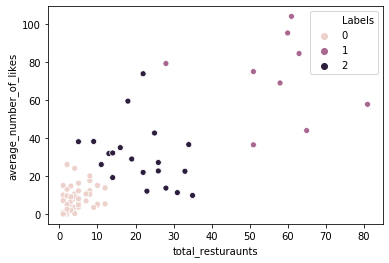

In [32]:
sns.scatterplot(x="total_resturaunts", y="average_number_of_likes", hue="Labels", data=totally_new_df.drop("Postcode", axis=1))

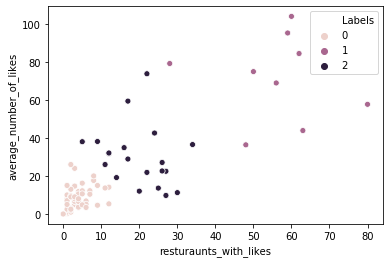

In [33]:
sns.scatterplot(x="resturaunts_with_likes", y="average_number_of_likes", hue="Labels", data=totally_new_df.drop("Postcode", axis=1))

In [34]:
# Now do a kmeans with location????
new_df = merged_venues.drop(merged_venues.columns[3:], axis=1)
new_df.head()

,Postcode,Postcode Latitude,Postcode Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1E,43.763573,-79.188711
4,M1E,43.763573,-79.188711


In [35]:
kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(new_df.drop('Postcode',axis=1))
# totally_new_df["Labels"] = kmeans.labels_
new_df["Labels"] = kmeans2.labels_

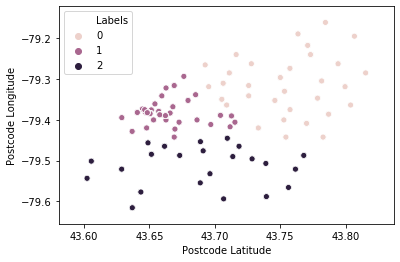

In [36]:
sns.scatterplot(x="Postcode Latitude", y="Postcode Longitude", hue="Labels", data=new_df.drop("Postcode", axis=1))

# sns.scatterplot(y="Postcode Latitude", x="Postcode Longitude", hue="Labels", data=new_df.drop("Postcode", axis=1))

In [37]:
matrix = [kmeans.labels_, kmeans2.labels_]
print(len(matrix[0]))
df = pd.DataFrame(matrix)
# df.columns = ["Labels1", "Labels2"]

89


In [25]:
print(len(kmeans.labels_))
print(len(kmeans2.labels_))

89
1182
